In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import csv
#import networkx as nx
import pickle
from scipy import stats

import sys
sys.path.insert(1, '../../')
from utils import *

In [27]:
plt.rcParams.update({'font.size': 13})

In [2]:
#dataset = 'hospital'
#dataset = 'high_school'
#dataset = 'conference'
#dataset = 'workplace'
dataset = 'pr_school'

In [3]:
weighted = True

In [4]:
thresholds = [0.04, 0.06, 0.08, 0.10, 0.12, 0.14, 0.16, 0.18, 0.20, 0.22]
if dataset == 'pr_school':
    thresholds = [0.02, 0.04, 0.06, 0.08, 0.10, 0.12, 0.14, 0.16]
mu = 0.1

# Load C and obtain r and s:

C is an array of weights, I need to put it in a matrix shape to compute r and s

In [5]:
def obtain_r_s_indices(C,edgelist):
    # put C in dict:
    C_dict = {}
    n = 0
    for edge in edgelist:
        C_dict[tuple(edge)] = C[n]
        C_dict[tuple(edge[::-1])] = C[n+1]
        n += 2
    # verify:
    if list(C_dict.values()) != list(C):
        print('error')
    nb_nodes = max(np.unique(list(C_dict.keys()))) + 1
    # put C_dict in matrix:
    C_mat = np.zeros((nb_nodes,nb_nodes))
    for link in C_dict:
        C_mat[link[0],link[1]] = C_dict[link]

    # receiver index:
    r = C_mat.sum(axis=0) # somma di ogni colonna
    # spreader index:
    s = C_mat.sum(axis=1) # somma di ogni riga

    return r, s

In [6]:
with open('../../data/pairwise/' + dataset + '_strength_edgelist_pairwise_sorted.pkl', 'rb') as f:
    edgelist = pickle.load(f)

In [7]:
r_list = []
s_list = []
for th in thresholds:
    if mu > 0:
        filename = "results/inf_treeSIR/C_mean_weighted_%s_th_%.2f_mu_%.3f.csv"%(dataset,th,mu)
    else:
        filename = "results/inf_treeSI/C_mean_weighted_%s_th_%.2f.csv"%(dataset,th)

    C = load_C_mean(filename)
    # verify:
    if 2*len(edgelist) != len(C):
        print('errore')
    r, s = obtain_r_s_indices(C,edgelist)
    r_list.append(r)
    s_list.append(s)
    

In [8]:
#r_list[0]

# Cosine similarity

### Receiver index

In [9]:
sim_r = np.full((len(thresholds),len(thresholds)),0.0)
for i in range(len(thresholds)-1):
    for j in range(i+1,len(thresholds)):
        sim_r[i,j] = cos_sim(r_list[i],r_list[j] )

0.9860206967837584 0.9999973344275498
../figs/cos_sim_receiver_pr_school_mu_0.10.pdf.pdf


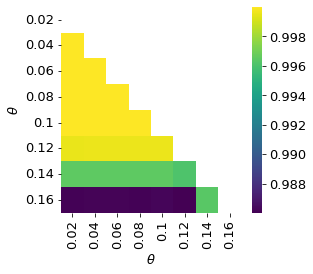

In [28]:
title='$r_i$ cosine sim.'
figname = '../figs/receiver_cos_sim_%s_mu_%.2f.pdf'%(dataset,mu)

plot_sim(sim_r, 
         mu, 
         thresholds,
         r'$\theta$',
         save=True, 
         figname=figname, 
         scale='independent',
         min_scale=0, 
         max_scale=1)

### Spreader index

In [29]:
sim_s = np.full((len(thresholds),len(thresholds)),0.0)
for i in range(len(thresholds)-1):
    for j in range(i+1,len(thresholds)):
        sim_s[i,j] = cos_sim(s_list[i],s_list[j] )

0.8607311831932849 0.9886897643514253
../figs/cos_sim_spreader_pr_school_mu_0.10.pdf.pdf


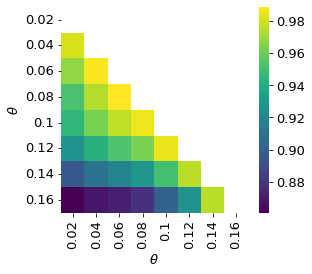

In [30]:
title='$s_i$ cosine sim.'
figname = '../figs/spreader_cos_sim_%s_mu_%.2f.pdf'%(dataset,mu)

plot_sim(sim_s, 
         mu, 
         thresholds,
         r'$\theta$',
         save=True, 
         figname=figname, 
         scale='independent',
         min_scale=0, 
         max_scale=1)

# Ranking correlation

### Receiver index

In [31]:
corr_r = np.full((len(thresholds),len(thresholds)),0.0)
for i in range(len(thresholds)-1):
    for j in range(i+1,len(thresholds)):
        corr_r[i,j] = stats.spearmanr(np.array(r_list[i]),np.array(r_list[j])).correlation

-0.07479264914583042 0.9211588058337927
../figs/rank_corr_receiver_pr_school_mu_0.10.pdf.pdf


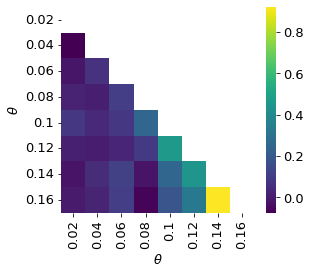

In [32]:
title='$r_i$ ranking corr.'
figname = '../figs/receiver_rank_corr_%s_mu_%.2f.pdf'%(dataset,mu)

plot_sim(corr_r, 
         mu, 
         thresholds,
         r'$\theta$',
         save=True, 
         figname=figname, 
         scale='independent',
         min_scale=0, 
         max_scale=1)

### Spreader index

In [33]:
corr_s = np.full((len(thresholds),len(thresholds)),0.0)
for i in range(len(thresholds)-1):
    for j in range(i+1,len(thresholds)):
        corr_s[i,j] = stats.spearmanr(np.array(s_list[i]),np.array(s_list[j])).correlation

0.744549734742115 0.9765651823994587
../figs/rank_corr_spreader_pr_school_mu_0.10.pdf.pdf


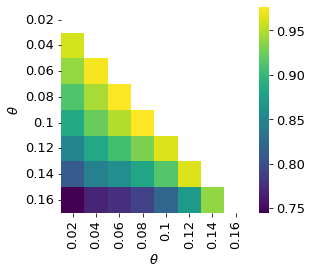

In [34]:
title='$s_i$ ranking corr.'
figname = '../figs/spreader_rank_corr_%s_mu_%.2f.pdf'%(dataset,mu)

plot_sim(corr_s, 
         mu, 
         thresholds,
         r'$\theta$',
         save=True, 
         figname=figname, 
         scale='independent',
         min_scale=0, 
         max_scale=1)

# Receiver vs. spreader

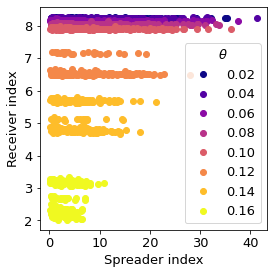

In [36]:
fig, ax = plt.subplots(nrows = 1, ncols = 1,figsize=(4,4))

colors = plt.cm.plasma(np.linspace(0,1,len(thresholds)))
for i in range(len(thresholds)):
    plt.plot(np.array(s_list[i]),
             np.array(r_list[i]),
             'o',
             c=colors[i],
             label=r'%.2f'%thresholds[i])
plt.xlabel('Spreader index')
plt.ylabel('Receiver index')
plt.tight_layout()
plt.legend(title=r'$\theta$')
plt.savefig('../figs/r_s_threshold_%s.pdf'%(dataset))
#plt.savefig('../figs/legend.pdf')
plt.show()